# LSTM을 이용한 AI/Human 텍스트 분류

이 노트북에서는 LSTM(Long Short-Term Memory) 모델을 사용하여 텍스트가 AI에 의해 작성되었는지 사람이 작성했는지를 분류하는 모델을 구현합니다.

## 목차
1. 데이터 로딩 및 전처리
2. 텍스트 처리 및 토큰화
3. 데이터 분할
4. LSTM 모델 생성
5. 모델 학습
6. 모델 평가
7. 예측 테스트

## 1. 데이터 로딩 및 전처리

필요한 라이브러리들을 import하고 데이터를 로드합니다.

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# matplotlib 한글 폰트 설정
import matplotlib.font_manager as fm

# 맑은 고딕 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 마이너스 기호 깨짐 해결
plt.rc('axes', unicode_minus=False)

# 그래프에서 그리드 설정
plt.rc('grid', linestyle='--', color='gray', alpha=0.5)

In [3]:
# 데이터 로드
data = pd.read_csv('ai-ga-dataset.csv')

# 텍스트 데이터 전처리: 제목과 초록을 합침
data['text'] = data['title'] + ' ' + data['abstract']

# 기본 정보 출력
print('데이터셋 크기:', len(data))
print('\n레이블 분포:')
print(data['label'].value_counts())
print('\n텍스트 길이 통계:')
data['text_length'] = data['text'].apply(len)
print(data['text_length'].describe())

데이터셋 크기: 28662

레이블 분포:
0    14331
1    14331
Name: label, dtype: int64

텍스트 길이 통계:
count     28662.000000
mean       1478.104703
std        1117.543548
min          24.000000
25%        1083.000000
50%        1365.000000
75%        1727.000000
max      122459.000000
Name: text_length, dtype: float64


## 2. 텍스트 처리 및 토큰화

텍스트를 처리하고 토큰화하는 과정을 구현합니다. 다음과 같은 단계를 수행합니다:
1. 텍스트 정제 (특수문자 제거, 소문자화 등)
2. 단어 사전 생성
3. 텍스트를 시퀀스로 변환
4. 시퀀스 패딩

In [4]:
# 텍스트 정제 함수
def clean_text(text):
    text = text.lower()  # 소문자화
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    return text

# 텍스트 정제 적용
data['cleaned_text'] = data['text'].apply(clean_text)

# 단어 사전 생성 함수
def build_vocab(texts, max_vocab_size=10000):
    words = [word for text in texts for word in text.split()]
    word_counter = Counter(words)
    vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counter.most_common(max_vocab_size-2)]
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    return word_to_idx

# 텍스트를 인덱스 시퀀스로 변환하는 함수
def text_to_sequence(text, word_to_idx, max_len=512):
    words = text.split()[:max_len]
    sequence = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in words]
    if len(sequence) < max_len:
        sequence = sequence + [word_to_idx['<PAD>']] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]
    return sequence

# Dataset 클래스 정의
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_len=512):
        self.texts = [text_to_sequence(text, word_to_idx, max_len) for text in texts]
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

## 3. 데이터 분할

데이터를 훈련(70%), 검증(10%), 테스트(20%) 세트로 분할합니다.

In [5]:
# 데이터 분할
X = data['cleaned_text'].values
y = data['label'].values

# 먼저 전체 데이터의 80%를 훈련용으로 분리
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ##1,2,3

# 나머지 80% 중에서 7:1 비율로 훈련셋과 검증셋 분리
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

print('훈련 데이터 크기:', len(X_train))
print('검증 데이터 크기:', len(X_val))
print('테스트 데이터 크기:', len(X_test))

# 단어 사전 생성
word_to_idx = build_vocab(X_train)
vocab_size = len(word_to_idx)
print('\n어휘 사전 크기:', vocab_size)

# 데이터셋 생성
train_dataset = TextDataset(X_train, y_train, word_to_idx)
val_dataset = TextDataset(X_val, y_val, word_to_idx)
test_dataset = TextDataset(X_test, y_test, word_to_idx)

# DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

훈련 데이터 크기: 20062
검증 데이터 크기: 2867
테스트 데이터 크기: 5733

어휘 사전 크기: 10000

어휘 사전 크기: 10000


## 4. LSTM 모델 생성

LSTM 모델의 구조를 정의하고 초기화합니다.

In [6]:
# LSTM 모델 클래스 정의
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout=0.5): ##
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                           dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        out = self.fc(hidden)
        return torch.sigmoid(out)

# 모델 파라미터 설정
embedding_dim = 128
hidden_dim = 64
n_layers = 2 # 2,3,4,5
dropout = 0.2

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, n_layers, dropout).to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTMClassifier(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 5. 모델 학습

정의된 LSTM 모델을 훈련 데이터로 학습시킵니다. 검증 세트를 사용하여 과적합을 모니터링합니다.

In [7]:
# 학습 함수 정의
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(texts)
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (output.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 검증 함수 정의
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)
            output = model(texts)
            loss = criterion(output.squeeze(), labels)
            
            total_loss += loss.item()
            predicted = (output.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 학습 실행
n_epochs = 5
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print('Early stopping triggered')
        break
    print()

Epoch 1/5:
Train Loss: 0.6904, Train Acc: 50.60%
Val Loss: 0.6902, Val Acc: 50.51%

Epoch 2/5:
Train Loss: 0.5630, Train Acc: 66.43%
Val Loss: 0.3262, Val Acc: 88.84%

Epoch 2/5:
Train Loss: 0.5630, Train Acc: 66.43%
Val Loss: 0.3262, Val Acc: 88.84%

Epoch 3/5:
Train Loss: 0.3620, Train Acc: 85.59%
Val Loss: 0.5838, Val Acc: 70.63%

Epoch 3/5:
Train Loss: 0.3620, Train Acc: 85.59%
Val Loss: 0.5838, Val Acc: 70.63%

Epoch 4/5:
Train Loss: 0.2386, Train Acc: 91.64%
Val Loss: 0.2149, Val Acc: 92.33%

Epoch 4/5:
Train Loss: 0.2386, Train Acc: 91.64%
Val Loss: 0.2149, Val Acc: 92.33%

Epoch 5/5:
Train Loss: 0.1545, Train Acc: 94.84%
Val Loss: 0.1538, Val Acc: 94.80%

Epoch 5/5:
Train Loss: 0.1545, Train Acc: 94.84%
Val Loss: 0.1538, Val Acc: 94.80%



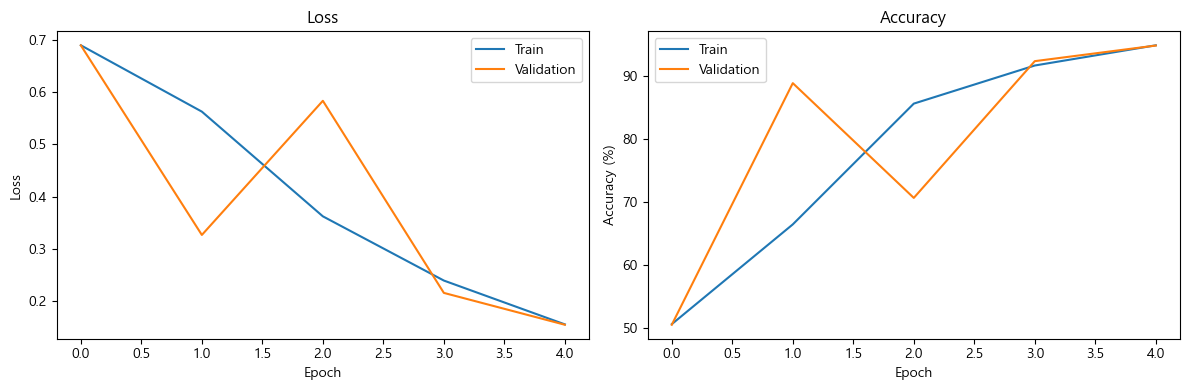

In [8]:
# 학습 곡선 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 6. 모델 평가

테스트 세트를 사용하여 모델의 최종 성능을 평가합니다.

In [9]:
# 최적의 모델 로드
model.load_state_dict(torch.load('best_model.pt'))

# 테스트 세트에서 모델 평가
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\2135319645.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Test Loss: 0.1542
Test Accuracy: 95.24%


## 7. 예측 테스트

학습된 모델을 사용하여 새로운 텍스트에 대한 예측을 수행합니다.

In [10]:
# 예측 함수 정의
def predict_text(model, text, word_to_idx, device):
    # 텍스트 전처리
    cleaned_text = clean_text(text)
    # 시퀀스 변환
    sequence = text_to_sequence(cleaned_text, word_to_idx)
    # 텐서 변환
    sequence_tensor = torch.tensor([sequence], dtype=torch.long).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(sequence_tensor)
        probability = output.item()
        prediction = 1 if probability > 0.5 else 0
    
    return prediction, probability

# 테스트 데이터에서 몇 개의 샘플을 선택하여 예측 테스트
test_samples = list(zip(X_test[:5], y_test[:5]))  # 처음 5개 샘플 선택

for text, true_label in test_samples:
    prediction, probability = predict_text(model, text, word_to_idx, device)
    print('텍스트:', text[:200], '...')  # 처음 200자만 출력
    print(f'실제 레이블: {true_label}')
    print(f'예측 레이블: {prediction}')
    print(f'AI 작성 확률: {probability:.4f}')
    print()

텍스트: climate change an enduring challenge for vectorborne disease prevention and control 

this paper investigates the challenges presented by climate change to vectorborne disease prevention and control t ...
실제 레이블: 1
예측 레이블: 1
AI 작성 확률: 0.9856

텍스트: an atlas of neural crest lineages along the posterior developing zebrafish at singlecell resolution neural crest cells nccs are vertebrate stem cells that give rise to various cell types throughout th ...
실제 레이블: 0
예측 레이블: 1
AI 작성 확률: 0.9909

텍스트: a history of zoonoses and sapronoses and research into them the history of these diseases and of their study is given in a brief chronological review of the most important events important epidemics a ...
실제 레이블: 0
예측 레이블: 0
AI 작성 확률: 0.0174

텍스트: untargeted metabolomics insights into newborns with congenital zika infection 

the zika virus is a growing global health concern as it has been linked to various adverse neurological outcomes includi ...
실제 레이블: 1
예측 레이블: 1
AI 작성 확률: 0.9877

텍스트: int

## 8. 예측 결과 분석 및 저장

전체 테스트 세트에 대한 예측 결과를 분석하고 엑셀 파일로 저장합니다.

예측 결과가 'prediction_results.xlsx' 파일로 저장되었습니다.


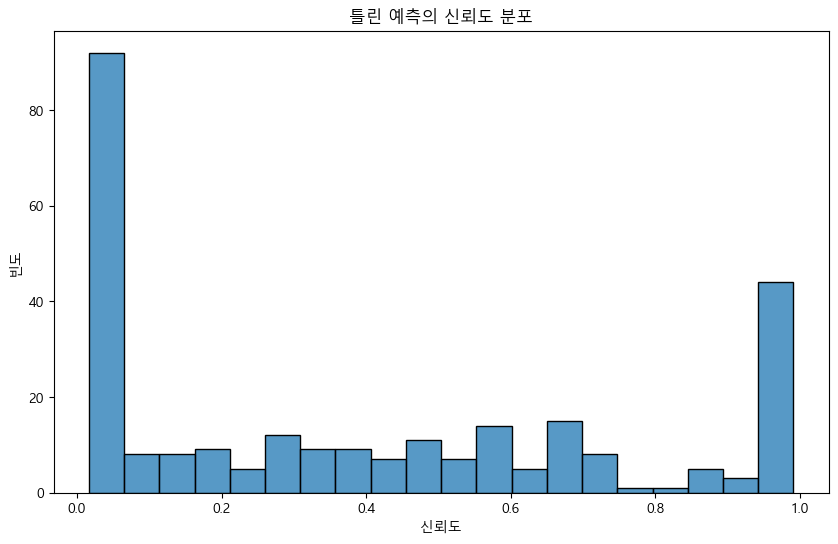

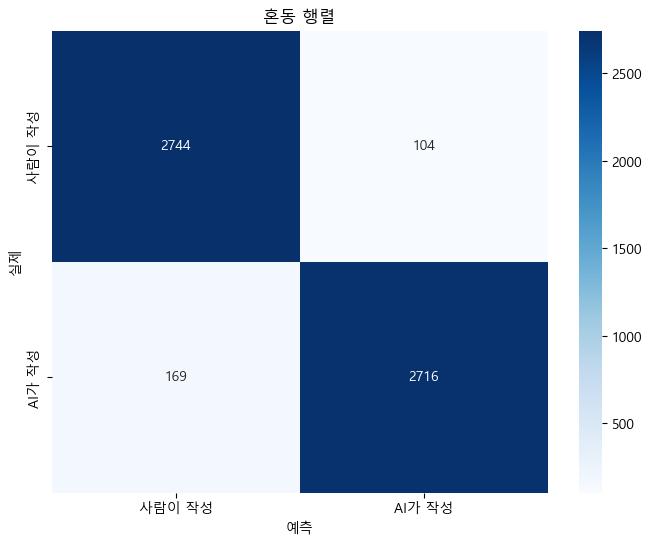

[[2744  104]
 [ 169 2716]]


In [11]:
# 전체 테스트 세트에 대한 예측 수행
test_results = []

for text, true_label in zip(X_test, y_test):
    prediction, probability = predict_text(model, text, word_to_idx, device)
    result = {
        'text': text,  # 전체 텍스트 저장
        'true_label': true_label,
        'predicted_label': prediction,
        'confidence': probability,
        'is_correct': true_label == prediction
    }
    test_results.append(result)

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(test_results)

# 잘못 예측한 케이스만 필터링
incorrect_predictions = results_df[~results_df['is_correct']]

# 레이블 이름 매핑
label_names = {0: '사람이 작성', 1: 'AI가 작성'}
results_df['true_label_name'] = results_df['true_label'].map(label_names)
results_df['predicted_label_name'] = results_df['predicted_label'].map(label_names)

# 엑셀 파일로 저장
with pd.ExcelWriter('prediction_results.xlsx', engine='openpyxl') as writer:
    # 전체 결과 시트
    results_df.to_excel(writer, sheet_name='전체 예측 결과', index=False)
    
    # 틀린 예측만 모은 시트
    incorrect_predictions.to_excel(writer, sheet_name='틀린 예측', index=False)
    
    # 요약 통계 계산
    summary_data = {
        '전체 테스트 데이터 수': [len(results_df)],
        '정확한 예측 수': [sum(results_df['is_correct'])],
        '틀린 예측 수': [len(incorrect_predictions)],
        '정확도': [sum(results_df['is_correct']) / len(results_df)],
        'AI로 잘못 분류된 사람 글 수': [len(results_df[(results_df['true_label']==0) & (results_df['predicted_label']==1)])],
        '사람 글로 잘못 분류된 AI 글 수': [len(results_df[(results_df['true_label']==1) & (results_df['predicted_label']==0)])]
    }
    
    # 요약 통계 시트
    pd.DataFrame(summary_data).to_excel(writer, sheet_name='요약 통계', index=False)

print("예측 결과가 'prediction_results.xlsx' 파일로 저장되었습니다.")

# 오분류된 케이스의 신뢰도 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=incorrect_predictions, x='confidence', bins=20)
plt.title('틀린 예측의 신뢰도 분포')
plt.xlabel('신뢰도')
plt.ylabel('빈도')
plt.show()

# 혼동 행렬 출력
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(results_df['true_label'], results_df['predicted_label'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['사람이 작성', 'AI가 작성'],
            yticklabels=['사람이 작성', 'AI가 작성'])
plt.title('혼동 행렬')
plt.xlabel('예측')
plt.ylabel('실제')
plt.show()

print(confusion_matrix(results_df['true_label'], results_df['predicted_label']))

## 9. 하이퍼파라미터 조정 및 체계적 실험

16가지 하이퍼파라미터 조합(n_layers × random_seed)에 대해 실험을 수행하고 결과를 CSV로 저장합니다.
각 조합마다 4개의 CSV 파일(00/01/10/11)을 생성합니다.

In [ ]:
# 하이퍼파라미터 조합 설정
layer_list = [2, 3, 4, 5]
seed_list = [1, 2, 3, 4]
n_epochs_fixed = 5
embedding_dim = 128
hidden_dim = 64
dropout = 0.2
batch_size = 32

# 결과를 저장할 메인 디렉토리 생성
import os
os.makedirs('results', exist_ok=True)

# 원본 데이터 저장 (모든 경우에 동일)
original_data = data[['title', 'abstract']].copy()

def save_results_by_label(true_labels, predictions, layer_n, seed, results_df_with_text):
    """
    예측 결과를 레이블-예측 조합(00, 01, 10, 11)별로 CSV 파일로 저장
    """
    # 해당 파라미터 조합의 폴더 생성
    folder_name = f'results/layer{layer_n}_sd{seed}'
    os.makedirs(folder_name, exist_ok=True)
    
    combinations = ['00', '01', '10', '11']
    
    for combo in combinations:
        true_label = int(combo[0])
        pred_label = int(combo[1])
        
        # 해당 조합에 맞는 행 필터링
        mask = (true_labels == true_label) & (predictions == pred_label)
        filtered_data = results_df_with_text[mask].copy()
        
        if len(filtered_data) > 0:
            # CSV 파일명 생성
            filename = f'{folder_name}/LSTM_{combo}_layer{layer_n}_epoch{n_epochs_fixed}_sd{seed}.csv'
            
            # 필요한 컬럼만 선택
            output_df = filtered_data[['title', 'abstract', 'true_label', 'full_text', 'processed_text', 'prediction']].copy()
            output_df.columns = ['title', 'abstract', 'label', 'full_text', 'processed_text', 'prediction']
            
            # CSV로 저장
            output_df.to_csv(filename, index=False, encoding='utf-8-sig')
            print(f'  ✓ {combo} - {len(filtered_data)}개 행 저장')

# 16가지 조합에 대해 실험 수행
print('=' * 80)
print('하이퍼파라미터 조정 실험 시작 (총 16개 조합)')
print('=' * 80)

for layer_n in layer_list:
    for seed in seed_list:
        experiment_num = (layer_list.index(layer_n) * len(seed_list) + seed_list.index(seed) + 1)
        print(f'\n[실험 {experiment_num}/16] n_layers={layer_n}, random_seed={seed}')
        print('-' * 80)
        
        # 난수 시드 설정
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # 데이터 분할 (시드 적용)
        X = data['cleaned_text'].values
        y = data['label'].values
        
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=seed)
        
        # 단어 사전 재생성
        word_to_idx_local = build_vocab(X_train)
        vocab_size_local = len(word_to_idx_local)
        
        # 데이터셋 생성
        train_dataset_local = TextDataset(X_train, y_train, word_to_idx_local)
        val_dataset_local = TextDataset(X_val, y_val, word_to_idx_local)
        test_dataset_local = TextDataset(X_test, y_test, word_to_idx_local)
        
        # DataLoader 생성
        train_loader_local = DataLoader(train_dataset_local, batch_size=batch_size, shuffle=True)
        val_loader_local = DataLoader(val_dataset_local, batch_size=batch_size)
        test_loader_local = DataLoader(test_dataset_local, batch_size=batch_size)
        
        # 모델 생성 (n_layers 변경)
        model_local = LSTMClassifier(vocab_size_local, embedding_dim, hidden_dim, layer_n, dropout).to(device)
        criterion_local = nn.BCELoss()
        optimizer_local = torch.optim.Adam(model_local.parameters(), lr=0.001)
        
        # 학습
        best_val_loss = float('inf')
        patience = 3
        patience_counter = 0
        
        for epoch in range(n_epochs_fixed):
            train_loss, train_acc = train_epoch(model_local, train_loader_local, criterion_local, optimizer_local, device)
            val_loss, val_acc = evaluate(model_local, val_loader_local, criterion_local, device)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model_local.state_dict(), f'temp_model_l{layer_n}_s{seed}.pt')
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                break
        
        # 최적 모델 로드 및 예측
        model_local.load_state_dict(torch.load(f'temp_model_l{layer_n}_s{seed}.pt'))
        test_loss, test_acc = evaluate(model_local, test_loader_local, criterion_local, device)
        print(f'Test Accuracy: {test_acc:.2f}%')
        
        # 전체 테스트 세트에 대한 예측
        test_results_local = []
        predictions_list = []
        true_labels_list = []
        
        for text, true_label in zip(X_test, y_test):
            prediction, probability = predict_text(model_local, text, word_to_idx_local, device)
            predictions_list.append(prediction)
            true_labels_list.append(int(true_label))
            test_results_local.append({
                'title': original_data.loc[data['cleaned_text'] == text].iloc[0]['title'],
                'abstract': original_data.loc[data['cleaned_text'] == text].iloc[0]['abstract'],
                'true_label': int(true_label),
                'full_text': data.loc[data['cleaned_text'] == text].iloc[0]['text'],
                'processed_text': text,
                'prediction': prediction
            })
        
        # DataFrame으로 변환
        results_df_local = pd.DataFrame(test_results_local)
        
        # 레이블-예측 조합별로 CSV 파일 저장
        print('CSV 파일 저장 중:')
        save_results_by_label(
            np.array(true_labels_list),
            np.array(predictions_list),
            layer_n,
            seed,
            results_df_local
        )
        
        # 임시 모델 파일 삭제
        os.remove(f'temp_model_l{layer_n}_s{seed}.pt')

print('\n' + '=' * 80)
print('모든 실험 완료! 결과는 results 폴더에 저장되었습니다.')
print('폴더 구조: results/layer{n}_sd{seed}/LSTM_*.csv')
print('=' * 80)

하이퍼파라미터 조정 실험 시작 (총 16개 조합)

[실험 1/16] n_layers=2, random_seed=1
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 97.33%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 2799개 행 저장
  ✓ 01 - 90개 행 저장
  ✓ 10 - 63개 행 저장
  ✓ 00 - 2799개 행 저장
  ✓ 01 - 90개 행 저장
  ✓ 10 - 63개 행 저장
  ✓ 11 - 2781개 행 저장

[실험 2/16] n_layers=2, random_seed=2
--------------------------------------------------------------------------------
  ✓ 11 - 2781개 행 저장

[실험 2/16] n_layers=2, random_seed=2
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 73.35%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 2800개 행 저장
  ✓ 01 - 64개 행 저장
  ✓ 10 - 1464개 행 저장
  ✓ 00 - 2800개 행 저장
  ✓ 01 - 64개 행 저장
  ✓ 10 - 1464개 행 저장
  ✓ 11 - 1405개 행 저장

[실험 3/16] n_layers=2, random_seed=3
--------------------------------------------------------------------------------
  ✓ 11 - 1405개 행 저장

[실험 3/16] n_layers=2, random_seed=3
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 54.53%
CSV 파일 저장 중:
  ✓ 00 - 333개 행 저장
CSV 파일 저장 중:
  ✓ 00 - 333개 행 저장
  ✓ 01 - 2576개 행 저장
  ✓ 10 - 31개 행 저장
  ✓ 01 - 2576개 행 저장
  ✓ 10 - 31개 행 저장
  ✓ 11 - 2793개 행 저장

[실험 4/16] n_layers=2, random_seed=4
--------------------------------------------------------------------------------
  ✓ 11 - 2793개 행 저장

[실험 4/16] n_layers=2, random_seed=4
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 91.31%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 2758개 행 저장
  ✓ 01 - 53개 행 저장
  ✓ 10 - 445개 행 저장
  ✓ 00 - 2758개 행 저장
  ✓ 01 - 53개 행 저장
  ✓ 10 - 445개 행 저장
  ✓ 11 - 2477개 행 저장

[실험 5/16] n_layers=3, random_seed=1
--------------------------------------------------------------------------------
  ✓ 11 - 2477개 행 저장

[실험 5/16] n_layers=3, random_seed=1
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 94.35%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 2728개 행 저장
  ✓ 01 - 161개 행 저장
  ✓ 10 - 163개 행 저장
  ✓ 00 - 2728개 행 저장
  ✓ 01 - 161개 행 저장
  ✓ 10 - 163개 행 저장
  ✓ 11 - 2681개 행 저장

[실험 6/16] n_layers=3, random_seed=2
--------------------------------------------------------------------------------
  ✓ 11 - 2681개 행 저장

[실험 6/16] n_layers=3, random_seed=2
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 97.85%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 2776개 행 저장
  ✓ 01 - 88개 행 저장
  ✓ 10 - 35개 행 저장
  ✓ 00 - 2776개 행 저장
  ✓ 01 - 88개 행 저장
  ✓ 10 - 35개 행 저장
  ✓ 11 - 2834개 행 저장

[실험 7/16] n_layers=3, random_seed=3
--------------------------------------------------------------------------------
  ✓ 11 - 2834개 행 저장

[실험 7/16] n_layers=3, random_seed=3
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 85.05%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 2650개 행 저장
  ✓ 01 - 259개 행 저장
  ✓ 00 - 2650개 행 저장
  ✓ 01 - 259개 행 저장
  ✓ 10 - 598개 행 저장
  ✓ 10 - 598개 행 저장
  ✓ 11 - 2226개 행 저장

[실험 8/16] n_layers=3, random_seed=4
--------------------------------------------------------------------------------
  ✓ 11 - 2226개 행 저장

[실험 8/16] n_layers=3, random_seed=4
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 70.02%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 2732개 행 저장
  ✓ 01 - 79개 행 저장
  ✓ 00 - 2732개 행 저장
  ✓ 01 - 79개 행 저장
  ✓ 10 - 1640개 행 저장
  ✓ 10 - 1640개 행 저장
  ✓ 11 - 1282개 행 저장

[실험 9/16] n_layers=4, random_seed=1
--------------------------------------------------------------------------------
  ✓ 11 - 1282개 행 저장

[실험 9/16] n_layers=4, random_seed=1
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 70.16%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 1317개 행 저장
  ✓ 00 - 1317개 행 저장
  ✓ 01 - 1572개 행 저장
  ✓ 10 - 139개 행 저장
  ✓ 01 - 1572개 행 저장
  ✓ 10 - 139개 행 저장
  ✓ 11 - 2705개 행 저장

[실험 10/16] n_layers=4, random_seed=2
--------------------------------------------------------------------------------
  ✓ 11 - 2705개 행 저장

[실험 10/16] n_layers=4, random_seed=2
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 93.32%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 2694개 행 저장
  ✓ 01 - 170개 행 저장
  ✓ 10 - 213개 행 저장
  ✓ 00 - 2694개 행 저장
  ✓ 01 - 170개 행 저장
  ✓ 10 - 213개 행 저장
  ✓ 11 - 2656개 행 저장

[실험 11/16] n_layers=4, random_seed=3
--------------------------------------------------------------------------------
  ✓ 11 - 2656개 행 저장

[실험 11/16] n_layers=4, random_seed=3
--------------------------------------------------------------------------------


C:\Users\samsung\AppData\Local\Temp\ipykernel_15512\4149751094.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_local.load_state_dict(torch.load(f'temp_model_l{la

Test Accuracy: 71.17%
CSV 파일 저장 중:
CSV 파일 저장 중:
  ✓ 00 - 2797개 행 저장
  ✓ 01 - 112개 행 저장
  ✓ 00 - 2797개 행 저장
  ✓ 01 - 112개 행 저장
  ✓ 10 - 1541개 행 저장
  ✓ 10 - 1541개 행 저장
  ✓ 11 - 1283개 행 저장

[실험 12/16] n_layers=4, random_seed=4
--------------------------------------------------------------------------------
  ✓ 11 - 1283개 행 저장

[실험 12/16] n_layers=4, random_seed=4
--------------------------------------------------------------------------------
